<a href="https://colab.research.google.com/github/AdamKimhub/Msproject1/blob/main/model_build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

if "google.colab" in sys.modules:
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    dataset_path = '/content/drive/My Drive/dataset'

    # Install required packages
    !pip install torch_geometric
    import torch
    from torch_geometric.data import Data, DataLoader

else:
    dataset_path = 'dataset'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.0 MB/s eta 0:00:00


## The data

In [2]:
# Load the data
# Training set
train_graphs = torch.load(f"{dataset_path}/combined/training.pt", weights_only=False)

# Validating set
val_graphs = torch.load(f"{dataset_path}/combined/validating.pt", weights_only=False)

# Testing set
test_graphs = torch.load(f"{dataset_path}/combined/testing.pt", weights_only=False)

In [3]:
# Create data loaders
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

## Build model

### import dependancies

In [4]:
# import dependancies
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, NNConv

In [5]:
class GNNModel(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim):
        super().__init__()
        # Edge NN maps edge_attr to weight matrix
        self.edge_nn = nn.Sequential(
            nn.Linear(edge_dim, 32),
            nn.ReLU(),
            nn.Linear(32, node_dim * hidden_dim)
        )

        self.conv1 = NNConv(node_dim, hidden_dim, self.edge_nn, aggr='mean')
        self.fc2 = nn.Linear(hidden_dim, 1)  # Regression output

    def forward(self, x, edge_index, edge_attr, batch):
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = global_mean_pool(x, batch)
        x = self.fc2(x)
        return x


# Instantiate model, optimizer, loss
# run the model in the gpu if the device has one
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instance of the model
model = GNNModel(node_dim=8, edge_dim=3, hidden_dim=32).to(device) # Without global features
# model = GNNModel(node_dim=8, edge_dim=3, global_dim=10, hidden_dim=32).to(device) # with global features


# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Loss function
loss_fn = nn.MSELoss()

In [6]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = loss_fn(out.view(-1), data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def evaluate(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = loss_fn(out.view(-1), data.y.view(-1))
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

# Train model
train_losses = []
val_losses = []
for epoch in range(1, 41):
    train_loss = train()
    val_loss = evaluate(val_loader)
    print(f'Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Test model
test_loss = evaluate(test_loader)
print(f'Test Loss: {test_loss:.4f}')

Epoch 001, Train Loss: 4.1712, Val Loss: 0.0756
Epoch 002, Train Loss: 0.0532, Val Loss: 0.0296
Epoch 003, Train Loss: 0.0321, Val Loss: 0.0295
Epoch 004, Train Loss: 0.0287, Val Loss: 0.0223
Epoch 005, Train Loss: 0.0259, Val Loss: 0.0212
Epoch 006, Train Loss: 0.0248, Val Loss: 0.0207
Epoch 007, Train Loss: 0.0232, Val Loss: 0.0231
Epoch 008, Train Loss: 0.0227, Val Loss: 0.0178
Epoch 009, Train Loss: 0.0228, Val Loss: 0.0205
Epoch 010, Train Loss: 0.0213, Val Loss: 0.0173
Epoch 011, Train Loss: 0.0206, Val Loss: 0.0189
Epoch 012, Train Loss: 0.0202, Val Loss: 0.0175
Epoch 013, Train Loss: 0.0203, Val Loss: 0.0252
Epoch 014, Train Loss: 0.0198, Val Loss: 0.0188
Epoch 015, Train Loss: 0.0198, Val Loss: 0.0177
Epoch 016, Train Loss: 0.0185, Val Loss: 0.0165
Epoch 017, Train Loss: 0.0192, Val Loss: 0.0161
Epoch 018, Train Loss: 0.0186, Val Loss: 0.0168
Epoch 019, Train Loss: 0.0184, Val Loss: 0.0175
Epoch 020, Train Loss: 0.0194, Val Loss: 0.0165
Epoch 021, Train Loss: 0.0182, Val Loss:

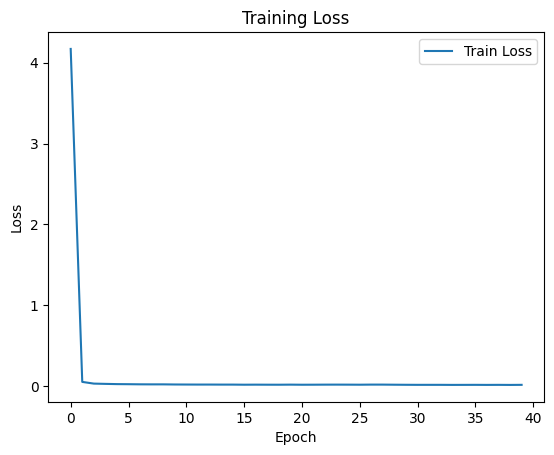

In [7]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [8]:
predicted_values = []
actual_values = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        predicted = model(data.x, data.edge_index, data.edge_attr, data.batch)

        # Convert to CPU, detach from graph, and flatten to NumPy
        predicted_values.append(predicted.cpu().detach().numpy())
        actual_values.append(data.y.cpu().detach().numpy())

# Concatenate all batches into single arrays
import numpy as np

predicted_values = np.concatenate(predicted_values, axis=0)
actual_values = np.concatenate(actual_values, axis=0)

# Now you can print or plot comparisons
for pred, actual in zip(predicted_values, actual_values):
    print(f"Predicted: {pred}, Actual: {actual}")


Predicted: [1.7652719], Actual: 1.8145999908447266
Predicted: [0.262328], Actual: 0.20589999854564667
Predicted: [0.17909503], Actual: 0.1923000067472458
Predicted: [1.047611], Actual: 1.1014000177383423
Predicted: [0.14020798], Actual: 0.2071000039577484
Predicted: [0.29968023], Actual: 0.34150001406669617
Predicted: [0.4929238], Actual: 0.3810499906539917
Predicted: [1.2197509], Actual: 1.2666000127792358
Predicted: [0.3908478], Actual: 0.42384999990463257
Predicted: [1.7824113], Actual: 1.808899998664856
Predicted: [0.28197992], Actual: 0.28060001134872437
Predicted: [0.15413347], Actual: 0.21220000088214874
Predicted: [0.19112784], Actual: 0.1899999976158142
Predicted: [1.0226659], Actual: 1.1432000398635864
Predicted: [0.50355554], Actual: 0.41200000047683716
Predicted: [0.3117873], Actual: 0.34119999408721924
Predicted: [1.04004], Actual: 1.142699956893921
Predicted: [0.3549991], Actual: 0.4032999873161316
Predicted: [0.34407246], Actual: 0.41499999165534973
Predicted: [1.0399798

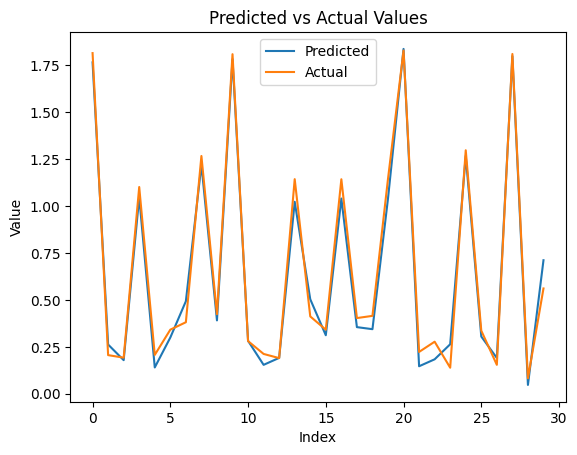

In [9]:
# Produce a graph
plt.plot(predicted_values[:30], label='Predicted')
plt.plot(actual_values[:30], label='Actual')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.show()